<a href="https://colab.research.google.com/github/ritujashinde97/DCGAN_Final_Project/blob/main/Final_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.5 MB/s 
     |████████████████████████████████| 2.4 MB 43.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.27.0
    Uninstalling tensorflow-io-gcs-filesystem-0.27.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.27.0


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

/usr/local/lib/python3.7/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.7/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.7/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.7/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.7/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.7/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10unique_

In [ ]:
IMG_H = 64
IMG_W = 64
IMG_C = 3

w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##Dataset
images_path = glob("/content/drive/MyDrive/DRIVE_64/*")
print("Dataset Size: ", len(images_path))


Dataset Size:  20


In [ ]:
def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.io.decode_png(image)
  #image = tfio.experimental.image.decode_tiff(image)
  #image = tf.io.decode_tiff(image)
  image = tf.image.resize(image,(IMG_H,IMG_W))
  image = tf.cast(image, tf.float32)
  image = (image - 127.5)/127.5
  return image

In [ ]:
if __name__ == "__main__":
  print("")
  #hyperparameters
  batch_size = 4 #no of training examples used in one iteration
  latent_dim = 4
  num_epochs = 10

In [ ]:
def tf_dataset(images_path, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(images_path)
  dataset = dataset.shuffle(buffer_size = 5)
  dataset = dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) #tunes the value at runtime
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
  return dataset 

In [ ]:
dataset = tf_dataset(images_path, batch_size)

for x in dataset:
  print(x.shape)

(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)


In [ ]:
#used in generator
#deconv -> transposed convolutions 
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
  x = Conv2DTranspose(
      filters = num_filters,
      kernel_size = kernel_size, #defines field view of the convolution(2D->3*3 pixels)
      kernel_initializer = w_init,
      padding = "same", #handles border of sample
      strides = strides, #step size while traversing the image
      use_bias = False
  )(inputs)

  if bn : 
    x = BatchNormalization()(x)  #for training very deep neural networks that standardizes the inputs to a layer for each mini-batch
    x = LeakyReLU(alpha=0.2)(x) #activation function
  return x

In [ ]:
#used in generator
def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation = True) :
  x = Conv2D(
      filters = num_filters,
      kernel_size = kernel_size,
      kernel_initializer = w_init,
      padding = padding,
      strides = strides
  )(inputs)

  if activation :
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
  
  return x

In [ ]:
#it mirrors disriminator, replacing Conv2D layers with Conv2Dtranspose
def build_generator(latent_dim):
  f = [2**i for i in range(5)][::-1]
  filters = 32
  output_strides = 16
  h_output = IMG_H // output_strides
  w_output = IMG_W // output_strides

  noise = Input(shape=(latent_dim), name = "gen_noise_input")

  x = Dense(f[0] * filters * h_output * w_output, use_bias = False)(noise)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Reshape((h_output, w_output, f[0] * filters))(x)
  print(x.shape)
  for i in range(1,5):
    x = deconv_block(x,
              num_filters = f[i]*filters,
              kernel_size = 5,
              strides = 2,
              bn = True       
                )
  print(x.shape)

  x = conv_block(x,
            num_filters = 3,
            kernel_size = 5,
            strides = 1,
            activation = False    
                 )
  fake_output = Activation("tanh")(x)

  return Model(noise, fake_output, name = "generator")

In [ ]:
def build_discriminator():
  f = [2**i for i in range(4)]
  filters = 64
  output_strides = 16
  h_output = IMG_H // output_strides
  w_output = IMG_W // output_strides

  image_input = Input(shape=(IMG_H, IMG_W, IMG_C), name = "images")
  x = image_input

  for i in range(0,4):
    x = conv_block(x,
             num_filters = f[i]*filters,
             kernel_size = 5,
             strides = 2,      
                   )
    
    x = Flatten()(x) 
    x = Dense(1)(x)
#Flatten layers are used when you got a multidimensional output and you want to make it linear to pass it onto a Dense layer.
#Dense Layer is used to classify image based on output from convolutional layers.
    return Model(image_input, x, name = "discriminator")

In [ ]:
g_model = build_generator(latent_dim)

(None, 4, 4, 512)
(None, 64, 64, 32)


In [ ]:
d_model = build_discriminator()

In [ ]:
g_model.summary()
d_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen_noise_input (InputLayer  [(None, 4)]              0         
 )                                                               
                                                                 
 dense (Dense)               (None, 8192)              32768     
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        32

In [ ]:
class GAN(Model) :
  def __init__ (self, discriminator, generator, latent_dim) :
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer,g_optimizer,loss_fn,metric):
    super(GAN,self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.metric = metric
  
  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]

    #Training Discriminator
    for _ in range(2):
      #Fake_images
      random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
      generated_images = self.generator(random_latent_vectors)
      generated_labels = tf.zeros((batch_size, 1))

      with tf.GradientTape() as ftape :
        predictions = self.discriminator(generated_images)
        d1_loss = self.loss_fn(generated_labels, predictions)
        d1_acc = self.metric(generated_labels, predictions)

      grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(grads,self.discriminator.trainable_weights))

      #Real_images
      labels = tf.ones((batch_size, 1))
      with tf.GradientTape() as rtape :
        predictions = self.discriminator(real_images)
        d2_loss = self.loss_fn(labels, predictions)
        d2_acc = self.metric(labels, predictions)

      grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(grads,self.discriminator.trainable_weights))


    #Training Generator
    random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
    misleading_labels = tf.ones((batch_size, 1))

    with tf.GradientTape() as gtape: 
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels,predictions)
      g_acc = self.metric(misleading_labels,predictions)

    grads = gtape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads,self.generator.trainable_weights))

    dict = {"d1_loss":d1_loss,"d2_loss":d2_loss,"g_loss":g_loss,"d1_acc":d1_acc,"d2_acc":d2_acc,"g_acc":g_acc}
    

    return dict;


In [ ]:
gan = GAN(d_model, g_model, latent_dim)


In [ ]:
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True, label_smoothing = 0.1 ) # compares each of the predicted probabilities to actual class output which can be either 0 or 1
d_optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
metric = tf.keras.metrics.Accuracy()
gan.compile(d_optimizer,g_optimizer,bce_loss_fn,metric)

In [ ]:
def save_plot(examples, epoch, n):
  examples = (examples + 1)/2.0
  for i in range(n*n):
    pyplot.subplot(n,n,i+1)
    pyplot.axis("off")
    pyplot.imshow(examples[i])
  filename = f"/content/drive/MyDrive/sample_images_drive/fake_images_epoch_{epoch+1}.eps"
  pyplot.savefig(filename, format='eps')
  pyplot.close()

In [ ]:
from keras.callbacks import History 
history = History()

In [ ]:
images_dataset = tf_dataset(images_path, batch_size)
#model fitting

history = gan.fit(images_dataset, epochs = num_epochs)
g_model.save("Saved Model/g_model.h5")
d_model.save("Saved Model/d_model.h5")
for epoch in range(num_epochs):
  n_samples = 1
  noise = np.random.normal(size=(n_samples, latent_dim))
  examples = g_model.predict(noise)
  save_plot(examples, epoch, int(np.sqrt(n_samples)))

Epoch 1/10
5/5 [==============================] - 6s 418ms/step - d1_loss: 0.6832 - d2_loss: 0.2420 - g_loss: 0.7080 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 2s 415ms/step - d1_loss: 0.5778 - d2_loss: 0.2055 - g_loss: 0.9055 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 2s 442ms/step - d1_loss: 0.3759 - d2_loss: 0.2312 - g_loss: 1.3100 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 2s 437ms/step - d1_loss: 0.2557 - d2_loss: 0.2153 - g_loss: 1.8652 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 2s 439ms/step - d1_loss: 0.2090 - d2_loss: 0.2054 - g_loss: 2.3842 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 2s 405ms/step - d1_loss: 0.2011 - d2_loss: 0.2023 - g_l

1/1 [==============================] - 0s 43ms/step


In [ ]:

print(history)
print(history.history.keys())

dict_keys(['d1_loss', 'd2_loss', 'g_loss', 'd1_acc', 'd2_acc', 'g_acc'])


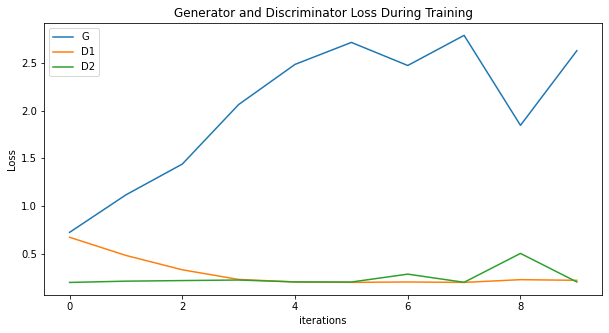

In [ ]:
pyplot.figure(figsize=(10,5))
pyplot.title("Generator and Discriminator Loss During Training")
pyplot.plot(history.history['g_loss'],label="G")
pyplot.plot(history.history['d1_loss'],label="D1")
pyplot.plot(history.history['d2_loss'],label="D2")
pyplot.xlabel("iterations")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

In [ ]:
images_dataset = tf_dataset(images_path, batch_size)
#model fitting
for epoch in range(num_epochs):
  gan.fit(images_dataset, epochs = 1)
  g_model.save("Saved Model/g_model.h5")
  d_model.save("Saved Model/d_model.h5")

  n_samples = 1
  noise = np.random.normal(size=(n_samples, latent_dim))
  examples = g_model.predict(noise)
  save_plot(examples, epoch, int(np.sqrt(n_samples)))



5/5 [==============================] - 4s 320ms/step - d1_loss: 0.6734 - d2_loss: 1.1909 - g_loss: 0.6246 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00


5/5 [==============================] - 2s 458ms/step - d1_loss: 0.8707 - d2_loss: 1.6653 - g_loss: 0.6460 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00


5/5 [==============================] - 3s 521ms/step - d1_loss: 1.1406 - d2_loss: 2.0707 - g_loss: 0.5287 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00


5/5 [==============================] - 1s 289ms/step - d1_loss: 1.0941 - d2_loss: 1.4533 - g_loss: 0.5679 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00


5/5 [==============================] - 1s 292ms/step - d1_loss: 0.8081 - d2_loss: 1.3405 - g_loss: 0.6651 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00


4/5 [=======================>......] - ETA: 0s - d1_loss: 0.7124 - d2_loss: 1.2437 - g_loss: 0.8087 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
g_model.save("Saved Model/g_model.h5")
d_model.save("Saved Model/d_model.h5")


In [ ]:

import numpy as np
import cv2
from tensorflow.keras.models import load_model
from matplotlib import pyplot

def save_plot(examples, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = "fakeimage.eps"
    pyplot.savefig(filename, format='eps')
    pyplot.close()

if __name__ == "__main__":
    model = load_model("/content/Saved Model/g_model.h5")

    n_samples = 1    ## n should always be a square of an integer.
    latent_dim = 4
    latent_points = np.random.normal(size=(n_samples, latent_dim))
    examples = model.predict(latent_points)
    save_plot(examples, int(np.sqrt(n_samples)))

1/1 [==============================] - 0s 162ms/step


In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

fake_image_path = glob("/content/drive/MyDrive/sample_images_drive/*") 
# scale an array of images to a new size
def scale_images(fake_image_path, new_shape):
	images_list = list()
	for image in fake_image_path:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
from pyparsing import Each
# prepare the inception v3 model
fid_same = []
fid_diff = []
num_of_iterations = [5,10,15]
for each in num_of_iterations :
  
  gan.fit(images_dataset, epochs = each)
  g_model.save("Saved Model/g_model.h5")
  d_model.save("Saved Model/d_model.h5")
  for epoch in range(each) :
    n_samples = 1
    noise = np.random.normal(size=(n_samples, latent_dim))
    examples = g_model.predict(noise)
    save_plot(examples, epoch, int(np.sqrt(n_samples)))

  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  # define two fake collections of images
  images1 = randint(0, 255, 10*32*32*3)
  images1 = images1.reshape((10,32,32,3))
  images2 = randint(0, 255, 10*32*32*3)
  images2 = images2.reshape((10,32,32,3))
  print('Prepared', images1.shape, images2.shape)
  # convert integer to floating point values
  images1 = images1.astype('float32')
  images2 = images2.astype('float32')
  # resize images
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  print('Scaled', images1.shape, images2.shape)
  # pre-process images
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  # fid between images1 and images1
  fid_same.append(calculate_fid(model, images1, images1))
  print('FID (same):', fid_same)
  # fid between images1 and images2
  fid_diff.append(calculate_fid(model, images1, images2))
  print('FID (different):', fid_diff)

Epoch 1/5
5/5 [==============================] - 2s 435ms/step - d1_loss: 0.3346 - d2_loss: 0.3142 - g_loss: 1.6025 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 2s 432ms/step - d1_loss: 0.4253 - d2_loss: 0.3619 - g_loss: 1.6169 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 2s 435ms/step - d1_loss: 0.3138 - d2_loss: 0.3391 - g_loss: 1.4538 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 4/5
5/5 [==============================] - 2s 431ms/step - d1_loss: 0.3917 - d2_loss: 0.3938 - g_loss: 1.3625 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 2s 440ms/step - d1_loss: 0.3894 - d2_loss: 0.4058 - g_loss: 1.3278 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00


1/1 [==============================] - 0s 40ms/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 2s 2s/step
FID (same): [-2.2849644154288375e-05]
1/1 [==============================] - 2s 2s/step
FID (different): [42.51583625236779]
Epoch 1/10
5/5 [==============================] - 2s 403ms/step - d1_loss: 0.5435 - d2_loss: 0.4834 - g_loss: 1.2197 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 2s 398ms/step - d1_loss: 0.3299 - d2_loss: 0.4121 - g_loss: 1.3209 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 2s 410ms/step - d1_loss: 0.3434 - d2_loss: 0.4050 - g_loss: 1.4201 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 2s 416ms/step - d1_loss: 0.3897 - d2_loss: 0.4389 - g_loss: 1.4227 - d1_acc: 0.0000e+00 - d2_acc: 0.00

1/1 [==============================] - 0s 83ms/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 2s 2s/step
FID (same): [-2.2849644154288375e-05, -2.8657292987432977e-05]
1/1 [==============================] - 3s 3s/step
FID (different): [42.51583625236779, 43.150280014234056]
Epoch 1/15
5/5 [==============================] - 2s 418ms/step - d1_loss: 0.4252 - d2_loss: 0.5357 - g_loss: 1.1728 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 2/15
5/5 [==============================] - 2s 419ms/step - d1_loss: 0.4789 - d2_loss: 0.5746 - g_loss: 1.1875 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 3/15
5/5 [==============================] - 2s 417ms/step - d1_loss: 0.4413 - d2_loss: 0.5850 - g_loss: 1.1671 - d1_acc: 0.0000e+00 - d2_acc: 0.0000e+00 - g_acc: 0.0000e+00
Epoch 4/15
5/5 [==============================] - 2s 425ms/step - d1_loss: 0.5090 - d2_loss: 0.6166 - g_los

1/1 [==============================] - 0s 44ms/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 2s 2s/step
FID (same): [-2.2849644154288375e-05, -2.8657292987432977e-05, -3.398382927683108e-05]
1/1 [==============================] - 2s 2s/step
FID (different): [42.51583625236779, 43.150280014234056, 44.81987750682479]


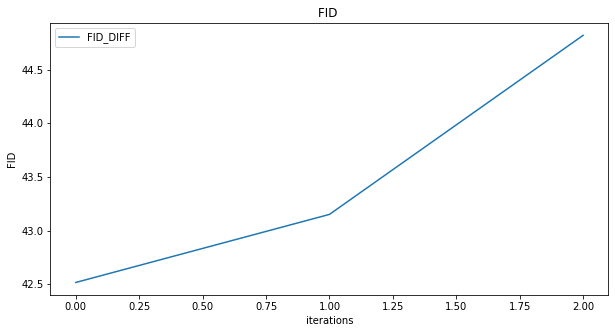

In [ ]:
pyplot.figure(figsize=(10,5))
pyplot.title("FID ")
pyplot.plot(fid_diff,label="FID_DIFF")
pyplot.xlabel("iterations")
pyplot.ylabel("FID")
pyplot.legend()
pyplot.show()

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

fake_image_path = glob("/content/drive/MyDrive/sample_images_drive/*") 
# scale an array of images to a new size
def scale_images(fake_image_path, new_shape):
	images_list = list()
	for image in fake_image_path:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 1s/step
FID (same): -0.000
1/1 [==============================] - 2s 2s/step
FID (different): 37.938


AttributeError: ignored

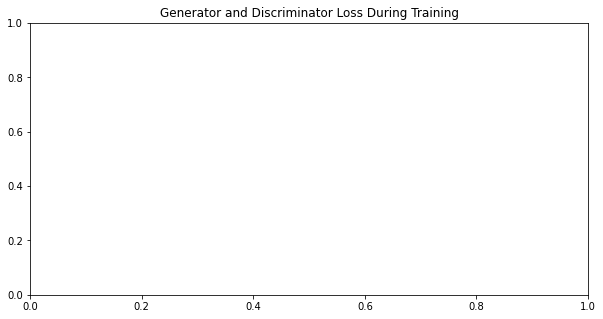

In [ ]:
pyplot.figure(figsize=(10,5))
pyplot.title("Generator and Discriminator Loss During Training")
pyplot.plot(gan.train_step.g_loss,label="G")
pyplot.plot(gan.train_step.d1_loss,label="D1")
pyplot.plot(gan.train_step.d2_loss,label="D2")
pyplot.xlabel("iterations")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

# New Section

# New Section